# Autoregressive Integrated Moving Average (ARIMA)

The <a href="https://en.wikipedia.org/wiki/Autoregressive_integrated_moving_average">ARIMA</a> model is a generalisation of an ARMA model that can be applied to non-stationary time series.

In [1]:
%matplotlib inline
import matplotlib
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from time import time

import statsmodels.api as sm
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.stattools import adfuller

In [2]:
matplotlib.rcParams['figure.figsize'] = (16, 9)
pd.options.display.max_columns = 999

## Load Dataset

In [3]:
df = pd.read_csv('../_datasets/daily-exchange-rates.csv', parse_dates=[0], index_col='DateTime')
print(df.shape)
df.head()

(7588, 8)


,ts1,ts2,ts3,ts4,ts5,ts6,ts7,ts8
DateTime,,,,,,,,
1990-01-01,0.7855,1.6110,0.861698,0.634196,0.211242,0.006838,0.5930,0.525486
1990-01-02,0.7818,1.6100,0.861104,0.633513,0.211242,0.006863,0.5940,0.523972
1990-01-03,0.7867,1.6293,0.861030,0.648508,0.211242,0.006975,0.5973,0.526316
1990-01-04,0.7860,1.6370,0.862069,0.650618,0.211242,0.006953,0.5970,0.523834
1990-01-05,0.7849,1.6530,0.861995,0.656254,0.211242,0.006940,0.5985,0.527426


## Define Parameters

Make predictions for four-week period using a training period of one year.

In [4]:
dataset_name = 'Daily Exchange Rates'
dataset_abbr = 'DER'
model_name = 'ARIMA'
context_length = 52*5 # 52 weeks
prediction_length = 4*5 # four weeks

## Define Error Metric

The mean absolute scaled error (MASE) will be used to evaluate the forecasts.

In [5]:
def calc_MASE(training_series, testing_series, prediction_series):
    a = training_series.iloc[1:].values
    b = training_series.iloc[:-1].values
    d = np.sum(np.abs(a-b)) / len(a)
    errors = np.abs(testing_series - prediction_series)
    return np.mean(errors) / d

## Example ARIMA Model

Exploration of how ARIMA models work using a single example time series.

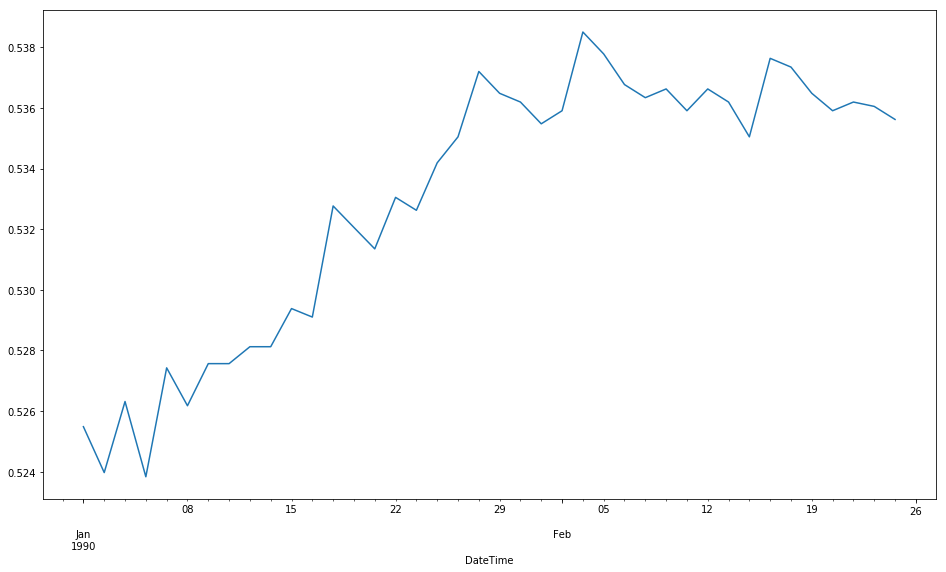

In [6]:
ts_ex = 'ts8'
df_ex = df.loc[:, ts_ex]

# Plot data from two months
df_ex.iloc[:4*5*2].plot();

### Time Series Decomposition

Decompose the example time series into trend, seasonal, and residual components.

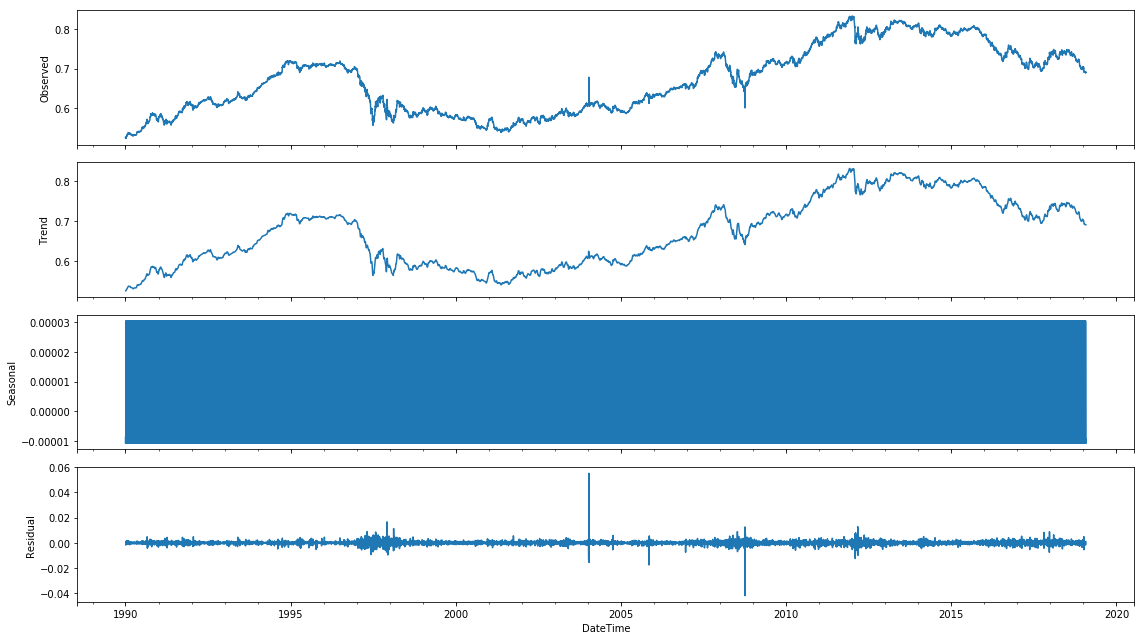

In [7]:
fig = seasonal_decompose(df_ex, model='additive').plot()

### Plot ACF and PACF

The <a href="https://en.wikipedia.org/wiki/Autocorrelation">Autocorrelation Function</a> (ACF) is the correlation of a signal with a delayed copy of itself as a function of delay.

The <a href="https://en.wikipedia.org/wiki/Partial_autocorrelation_function">Partial Autocorrelation Function</a> (PACF) is the partial correlation of a signal with a delayed copy of itself, controlling for the values of the time series at all shorter delays, as a function of delay.

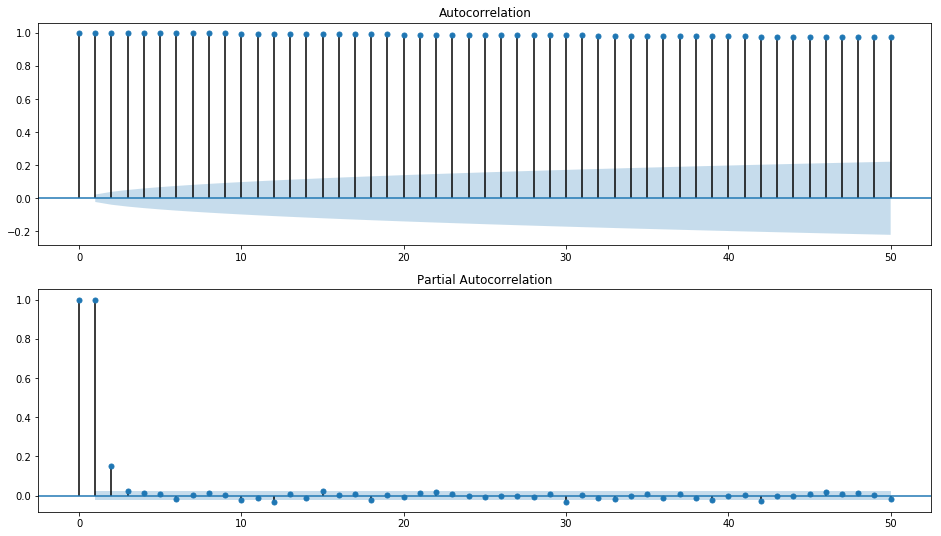

In [9]:
fig, ax = plt.subplots(2)
ax[0] = sm.graphics.tsa.plot_acf(df_ex, lags=50, ax=ax[0])
ax[1] = sm.graphics.tsa.plot_pacf(df_ex, lags=50, ax=ax[1])

There is no seasonality.

### Build Model

Grid search will be implemented to identify optimal parameters for the ARIMA(p, d, q) model, using the following possible values:

In [10]:
from itertools import product

ps = range(0, 5) # Up to 4 AR terms
ds = range(0, 2) # Either no or first differencing
qs = range(0, 5) # Up to 4 MA terms

params = product(ps, ds, qs)
params_list = list(params)
print("Number of parameter combinations for grid search: {}".format(len(params_list)))

Number of parameter combinations for grid search: 50


In [11]:
def optimiseARIMA(time_series, params_list=params_list, test_length=prediction_length, train_length=context_length):
    ts = time_series.iloc[-(test_length+train_length):]
    ts_train = ts.iloc[:-test_length]
    ts_test = ts.iloc[-test_length:]
    
    # Select the best model using a holdout validation period
    val_length = test_length
    ts_train_val = ts.iloc[:-(test_length+val_length)]
    ts_val = ts.iloc[-(test_length+val_length):-test_length]
    
    results = []
    
    for params in params_list:
        p = params[0]
        d = params[1]
        q = params[2]
        
        # try/except loop in case model fails to converge for given parameters
        try:
            arima = sm.tsa.ARIMA(ts_train_val, order=(p, d, q)).fit()
        except:
            continue
        
        # Make predictions for validation holdout set and update best model if necessary
        val_pred = arima.predict(start=ts_val.index[0], end=ts_val.index[-1], dynamic=True)
        MASE = calc_MASE(ts_train, ts_val, val_pred)

        results.append([params, MASE])
            
    df_results = pd.DataFrame(results)
    df_results.columns = ['parameters', 'MASE']
    df_results = df_results.sort_values(by='MASE', ascending=True).reset_index(drop=True)
    
    # Retrain model with best parameters using all training data and generate test forecast
    # Use loop to fall back to next best model in case training fails using full dataset
    trained = False
    model_rank = 1
    while not trained:
        train_params = df_results.iloc[model_rank-1, 0]
        try:
            arima = sm.tsa.ARIMA(ts_train, order=train_params).fit()
            trained = True
        except:
            model_rank += 1
        
    summary = arima.summary()
    
    # Start index must be greater than q. Fill missing initial entries with first actual prediction
    fcst = arima.predict(start=ts_train.index[train_params[2]+1], end=ts_test.index[-1])
    first_pred = fcst[0]
    fcst = np.concatenate([np.array([first_pred for i in range(train_params[2]+1)]), fcst])
    fcst = pd.DataFrame(data=fcst, index=ts.index, columns=['pred%s' % ts.name[2:]])
    
    return fcst, train_params, summary

In [12]:
import warnings
warnings.filterwarnings('ignore')

In [13]:
%%time
fcst, train_params, summary = optimiseARIMA(df_ex)
df_ex = pd.concat([df_ex, fcst], axis=1)
print("Best model: ARIMA{}".format(train_params))
print(summary)

Best model: ARIMA(2, 0, 3)
                              ARMA Model Results                              
Dep. Variable:                    ts8   No. Observations:                  260
Model:                     ARMA(2, 3)   Log Likelihood                1216.206
Method:                       css-mle   S.D. of innovations              0.002
Date:                Sun, 10 Mar 2019   AIC                          -2418.412
Time:                        23:24:22   BIC                          -2393.487
Sample:                    01-04-2018   HQIC                         -2408.392
                         - 01-02-2019                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.7273      0.005    133.554      0.000       0.717       0.738
ar.L1.ts8      1.9873      0.008    247.069      0.000       1.972       2.003
ar.L2.ts8     -0.9876    

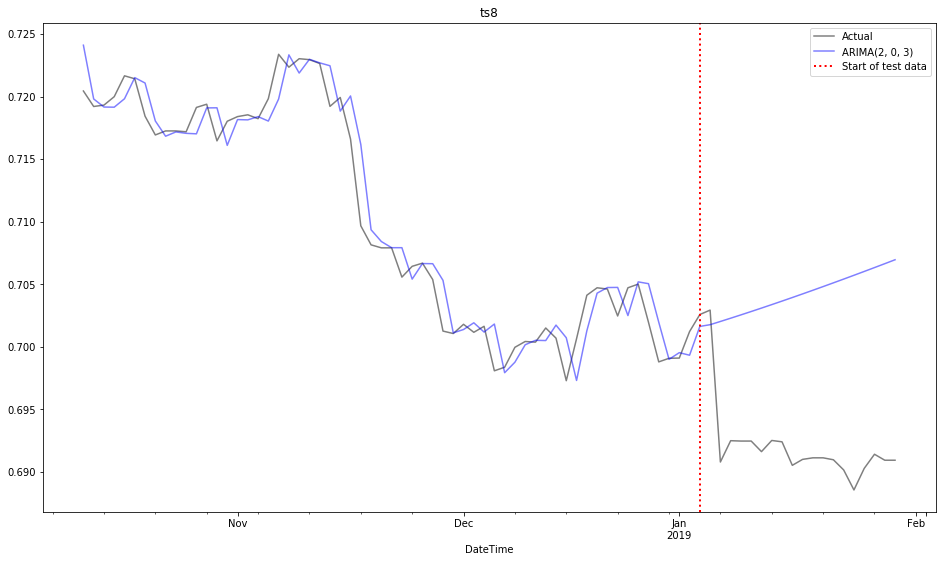

In [14]:
# Example forecast
fcst0 = df_ex.copy()
fcst0['pred%s' % ts_ex[2:]][fcst0['pred%s' % ts_ex[2:]] < 0] = 0

fcst0.iloc[-4*prediction_length:, 0].plot(label='Actual', c='k', alpha=0.5)
fcst0.iloc[-4*prediction_length:, 1].plot(label='ARIMA%s' % str(train_params), c='b', alpha=0.5)
plt.axvline(x=fcst0.index[-prediction_length], linestyle=':', linewidth=2, color='r', label='Start of test data')
plt.legend()
plt.title(ts_ex);

## Evaluating ARIMA

To evaluate ARIMA, forecasts will be generated for each time series using the grid search methodology shown above (with subsequent zeroing of the negative values). MASE will be calculated for each individual time series, and the mean of all these scores will be used as the overall accuracy metric for ARIMA on this dataset.

In [15]:
parameters = []
results = df.iloc[-(prediction_length+context_length):].copy()

tic = time()
for i, col in enumerate(df.columns):
    if i % 10 == 0:
        toc = time()
        print("Running predictions for {}. Cumulative time: {:.1f} minutes.".format(col, (toc-tic)/60))
        
    # Prepare DataFrame for selected column
    dft = df.loc[:, col]
    
    # Find best model
    fcst, train_params, summary = optimiseARIMA(dft)
    # Add predictions to results DataFrame
    results['pred%s' % col[2:]] = fcst.values
    # Store model parameteres for reference
    parameters.append(train_params)

toc = time()
print("Finished! Total run time: {:.1f} minutes.".format((toc-tic)/60))

Running predictions for ts1. Cumulative time: 0.0 minutes.
Finished! Total run time: 2.6 minutes.


In [16]:
results0 = results.copy()
results0[results0 < 0] = 0
results0.head()

,ts1,ts2,ts3,ts4,ts5,ts6,ts7,ts8,pred1,pred2,pred3,pred4,pred5,pred6,pred7,pred8
DateTime,,,,,,,,,,,,,,,,
2018-01-04,0.750835,1.415458,0.753580,1.022390,0.153499,0.008843,0.668695,0.728674,0.765572,1.422402,0.758787,1.022258,0.153486,0.008846,0.697280,0.740002
2018-01-05,0.754006,1.423700,0.758492,1.026589,0.154089,0.008820,0.671885,0.729695,0.765572,1.422402,0.758787,1.022258,0.153486,0.008846,0.697280,0.740002
2018-01-08,0.761296,1.436678,0.763280,1.031475,0.153727,0.008856,0.684556,0.736901,0.765572,1.422402,0.758787,1.026344,0.153976,0.008823,0.697280,0.740002
2018-01-09,0.766372,1.438849,0.770440,1.037404,0.154677,0.008888,0.691085,0.740247,0.765572,1.434801,0.763421,1.031099,0.153720,0.008859,0.698979,0.740002
2018-01-10,0.767489,1.439263,0.770980,1.043368,0.155063,0.008890,0.692113,0.742572,0.765572,1.439732,0.770582,1.036869,0.154567,0.008891,0.702172,0.740002


In [17]:
MASEs = []
for i, col in enumerate(df.columns):
    MASEs.append(calc_MASE(results0[col].iloc[-(context_length + prediction_length):-prediction_length],
                           results0[col].iloc[-prediction_length:],
                           results0['pred%s' % str(i+1)].iloc[-prediction_length:]))

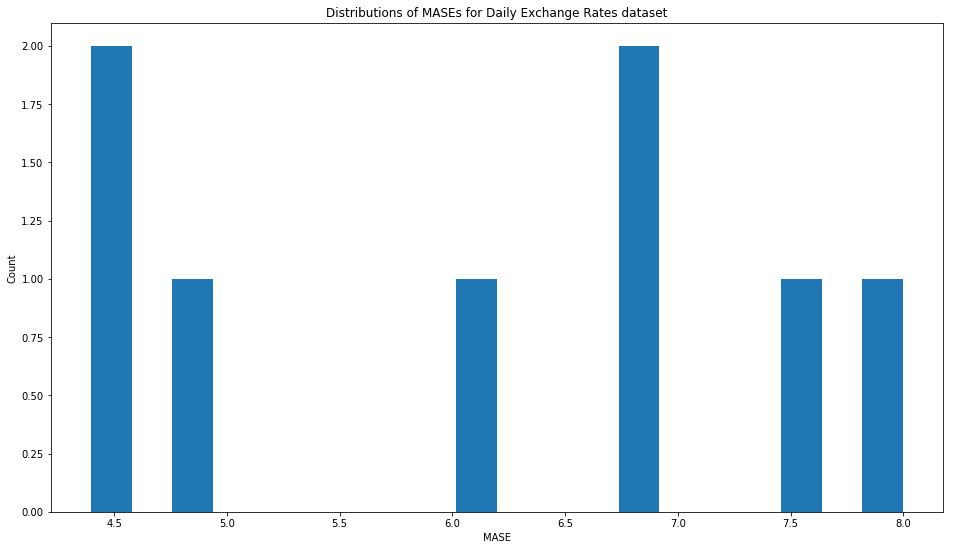

In [18]:
fig, ax = plt.subplots()
ax.hist(MASEs, bins=20)
ax.set_title('Distributions of MASEs for {} dataset'.format(dataset_name))
ax.set_xlabel('MASE')
ax.set_ylabel('Count');

In [19]:
MASE = np.mean(MASEs)
print("Overall MASE: {:.4f}".format(MASE))

Overall MASE: 6.1503


Show some example forecasts.

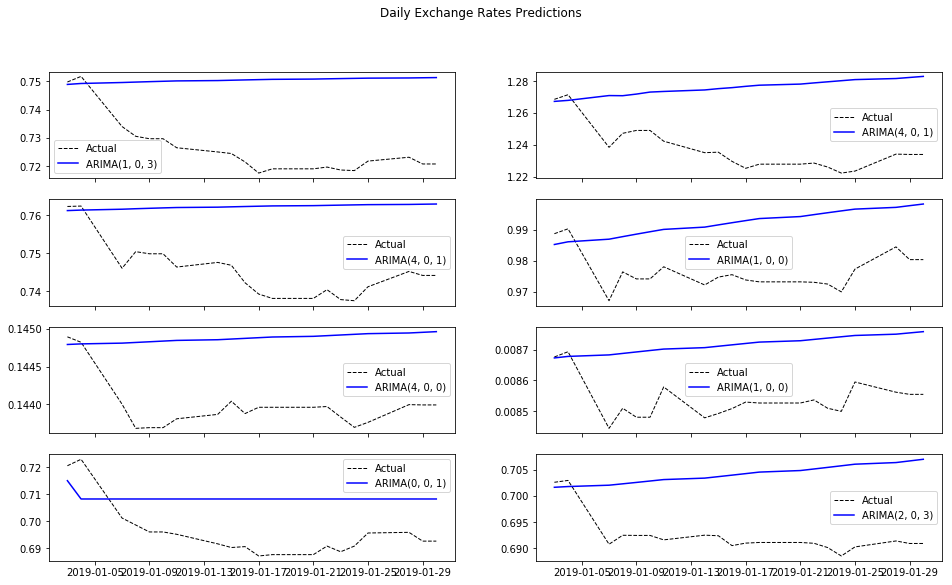

In [20]:
fig, ax = plt.subplots(4, 2, sharex=True)
ax = ax.ravel()

for col in range(1, 9):
    ax[col-1].plot(results0.index[-prediction_length:], results0['ts%s' % col].iloc[-prediction_length:],
                   label='Actual', c='k', linestyle='--', linewidth=1)
    ax[col-1].plot(results0.index[-prediction_length:], results0['pred%s' % col].iloc[-prediction_length:],
                   label='ARIMA%s' % str(parameters[col-1]), c='b')
    ax[col-1].legend()
fig.suptitle('{} Predictions'.format(dataset_name));

Clearly, some of the time series adopt an ARIMA(0,1,0) model which just flatlines at zero for the test period. The higher order models appear to do a better job of generating forecasts, although when such a large number of data points are zero, always forecasting zero is presumably a strategy that performs quite well.

Store the predictions and accuracy score for the ARIMA models.

In [21]:
import pickle
    
with open('{}-MASE.pkl'.format(dataset_abbr), 'wb') as f:
    pickle.dump(MASE, f)
    
with open('../_results/{}/{}-results.pkl'.format(model_name, dataset_abbr), 'wb') as f:
    pickle.dump(results.iloc[-prediction_length:], f)